In [21]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from model.model import get_model
from data_loader import TrainDataModule, get_all_test_dataloaders, get_normal_test_dataloader, get_train_dataloader

# autoreload imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline


# with open("./configs/ganomaly_config.yaml", "r") as f:
best = "/home/marcel/Projects/uni/mad_seminar/models/dulcet-music-21/ganomaly_config.yaml"
test = "./configs/ganomaly_config.yaml"
with open(best, "r") as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config["seed"])

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])


Global seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
img_csv='./data/splits/absent_septum.csv' 
 len(self.img_paths)=1
img_csv='./data/splits/artefacts.csv' 
 len(self.img_paths)=16
img_csv='./data/splits/craniatomy.csv' 
 len(self.img_paths)=15
img_csv='./data/splits/dural.csv' 
 len(self.img_paths)=7
img_csv='./data/splits/ea_mass.csv' 
 len(self.img_paths)=4
img_csv='./data/splits/edema.csv' 
 len(self.img_paths)=18
img_csv='./data/splits/encephalomalacia.csv' 
 len(self.img_paths)=1
img_csv='./data/splits/enlarged_ventricles.csv' 
 len(self.img_paths)=19
img_csv='./data/splits/intraventricular.csv' 
 len(self.img_paths)=1
img_csv='./data/splits/lesions.csv' 
 len(self.img_paths)=22
img_csv='./data/splits/mass.csv' 
 len(self.img_paths)=22
img_csv='./data/splits/posttreatment.csv' 
 len(self.img_paths)=44
img_csv='./data/splits/resection.csv' 
 len(self.img_paths)=10
img_csv='./data/splits/sinus.csv' 
 len(self.img_paths)=2
img_csv='./data/splits/w

In [22]:
# load model from checkpit
from model.ganomaly.lightning_model import Ganomaly


model = get_model(config)

# model = Ganomaly(
#     batch_size=256,
#     input_size=(64, 64),
#     latent_vec_size=256,  # 256,
#     wadv=1,
#     wcon=50,
#     wenc=1,
#     # lr=config["lr"],
#     beta1=0.5,
#     beta2=0.999,
# )
# custom_cp = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_1/checkpoints/epoch=149-step=300.ckpt"
# Initialize the model by loading from the checkpoint
best_cp = "models/dulcet-music-21/epoch=149-step=2400.ckpt"
cp = "/home/marcel/Projects/uni/mad_seminar/models/whole-pyramid-22/epoch=146-step=2352.ckpt"
model.load_state_dict(torch.load(best_cp)["state_dict"])
# model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

Loading model ganomaly


In [23]:
from ganomaly_eval import GanomalyEvaluator, EvalType

normal_test_dataloader = get_normal_test_dataloader(
    config["split_dir"], config["target_size"], config["batch_size"]
)
# train_dataloader = get_train_dataloader(config['split_dir'], config['target_size'], config['batch_size'])

train_data_module = TrainDataModule(
    split_dir=config["split_dir"],
    target_size=config["target_size"],
    batch_size=config["batch_size"],
    # debug=True,
)
all_data_loaders = test_dataloaders.copy()
all_data_loaders.update({"normal": normal_test_dataloader})


evaluator = GanomalyEvaluator(model, all_data_loaders)
evaluator.evaluate_model(normalize=True)

train_evaluator = GanomalyEvaluator(
    model, {"train": train_data_module.train_dataloader()}
)
train_evaluator.evaluate_model(normalize=True)

img_csv='./data/splits/normal_test.csv' 
 len(self.img_paths)=30
Using 581 IXI images and 130 fastMRI images for training. Using 15 images for validation.


In [24]:
dl = train_data_module.train_dataloader()
for b in dl:
    print(b[0].shape)
    print(b[0].min(),b[0].max())
    break

torch.Size([1, 128, 128])
metatensor(-1.) metatensor(1.)


## Stats

In [25]:
# evaluator.normalize_scores()
evaluator.print_stats_table()

                    Statistics of Anomaly Scores per categroy                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pathology           ┃ Minimum ┃ Maximum ┃ Median ┃ Mean ┃ Variance ┃ #Samples ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ absent_septum       │    0.35 │    0.35 │   0.35 │ 0.35 │     0.00 │        1 │
│ artefacts           │    0.12 │    0.49 │   0.37 │ 0.35 │     0.01 │       16 │
│ craniatomy          │    0.25 │    0.78 │   0.43 │ 0.45 │     0.03 │       15 │
│ dural               │    0.31 │    0.45 │   0.41 │ 0.39 │     0.00 │        7 │
│ ea_mass             │    0.35 │    0.38 │   0.35 │ 0.36 │     0.00 │        4 │
│ edema               │    0.21 │    0.66 │   0.36 │ 0.36 │     0.01 │       18 │
│ encephalomalacia    │    0.44 │    0.44 │   0.44 │ 0.44 │     0.00 │        1 │
│ enlarged_ventricles │    0.08 │    0.81 │   0.41 │ 0.42 │     0.03 │       19 │
│ intraventricular    │    0.37 │    0.37 │   0.37 │ 0.37 │     0.00 │        1 │
│ lesions             │    0.13 │    0.58 │   0.28 │ 0.34 │     0.01 │       22 │
│ mass                │    0.15 │    0.67 │   0.44 │ 0.42 │     0.02 │       22 │
│ posttreatment       │    0.05 │    0.79 │   0.33 │ 0.34 │     0.03 │       44 │
│ resection           │    0.27 │    0.78 │   0.51 │ 0.52 │     0.04 │       10 │
│ sinus               │    0.27 │    0.28 │   0.27 │ 0.27 │     0.00 │        2 │
│ wml                 │    0.26 │    0.49 │   0.28 │ 0.36 │     0.01 │        5 │
│ other               │    0.27 │    0.44 │   0.35 │ 0.34 │     0.00 │        5 │
│ normal              │    0.00 │    1.00 │   0.32 │ 0.35 │     0.06 │       30 │
└─────────────────────┴─────────┴─────────┴────────┴──────┴──────────┴──────────┘

In [26]:
train_evaluator.print_stats_table()

               Statistics of Anomaly Scores per categroy               
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pathology ┃ Minimum ┃ Maximum ┃ Median ┃ Mean ┃ Variance ┃ #Samples ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ train     │    0.00 │    1.00 │   0.26 │ 0.27 │     0.02 │      711 │
└───────────┴─────────┴─────────┴────────┴──────┴──────────┴──────────┘

## Histograms

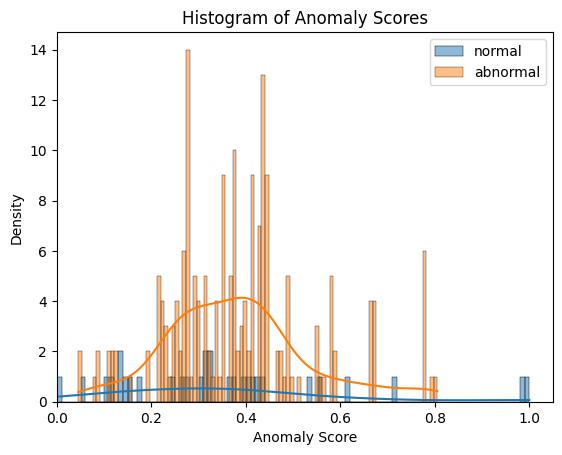

In [27]:
evaluator.histplot()

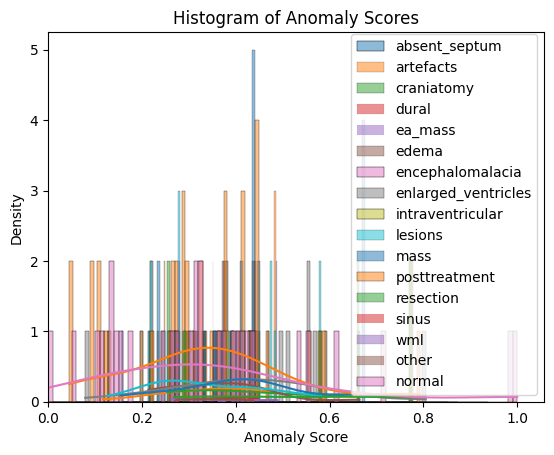

In [28]:
evaluator.histplot(eval_type=EvalType.ALL)

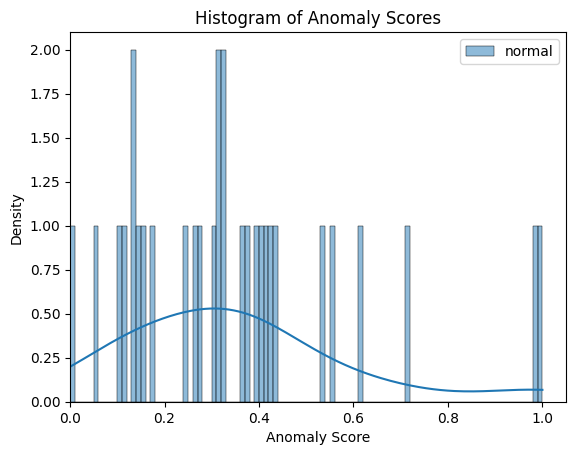

In [29]:
evaluator.histplot(EvalType.NORMAL)

tra

In [30]:
# train_evaluator.histplot(EvalType.TRAIN)

# Metrics

## Find optimal threshold

In [31]:
optimal_threshold = evaluator.find_optimal_threshold_f1()
print(optimal_threshold)
if optimal_threshold == 0:
    optimal_threshold = 0.03

0.9820479


/home/marcel/Projects/uni/mad_seminar/ganomaly_eval.py:291: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


## General classification report

In [32]:
evaluator.classification_report(threshold=optimal_threshold)

              precision    recall  f1-score   support

           0       0.13      0.97      0.23        30
           1       0.00      0.00      0.00       192

    accuracy                           0.13       222
   macro avg       0.07      0.48      0.12       222
weighted avg       0.02      0.13      0.03       222



## Confusion matrix

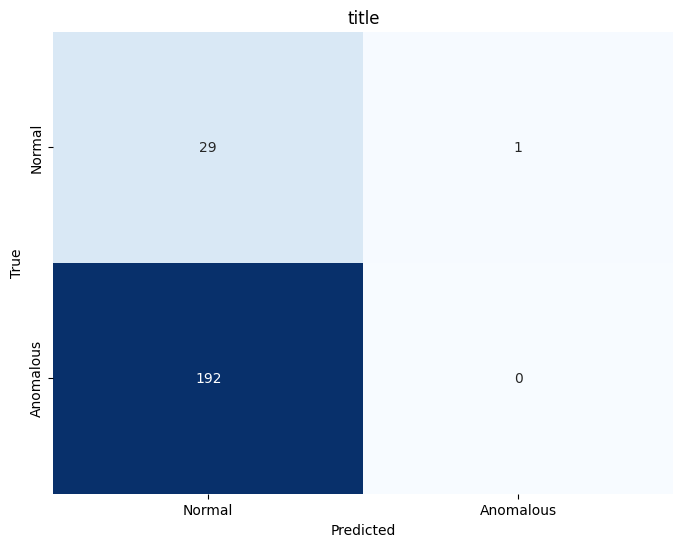

In [33]:
evaluator.plot_confusion_matrix(threshold=optimal_threshold)

## AUROC

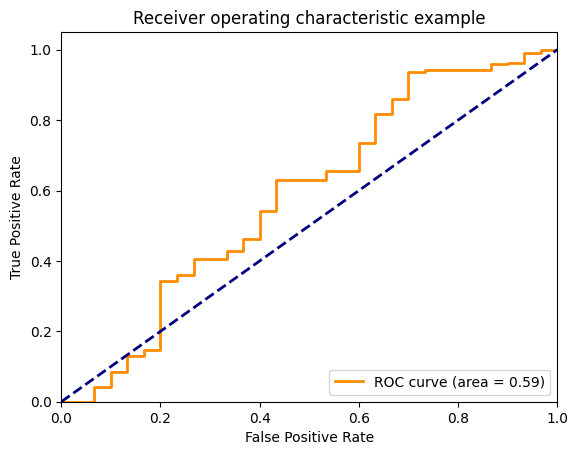

In [34]:
# evaluator.roc_auc_score()
evaluator.plot_auroc()

## PRC AUC

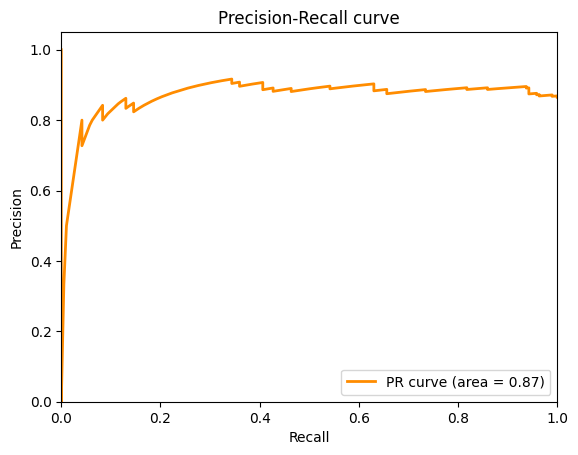

In [35]:
# evaluator.prc_auc_score()
evaluator.plot_auprc()

# Reconstructions

## Test set - Normal data

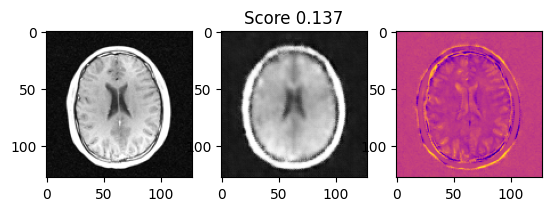

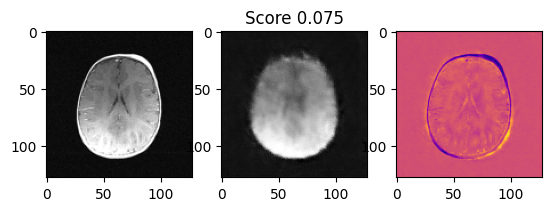

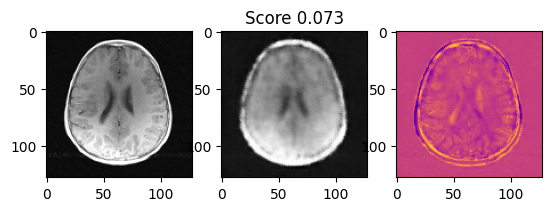

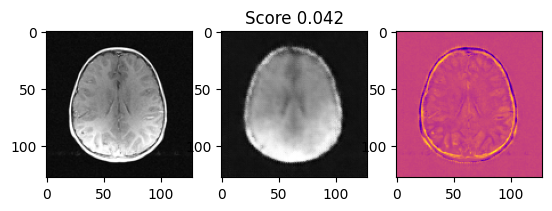

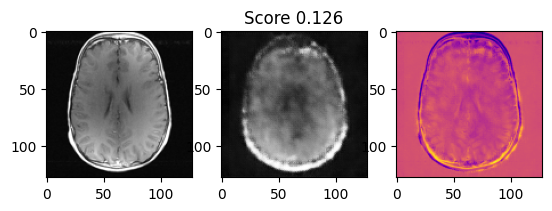

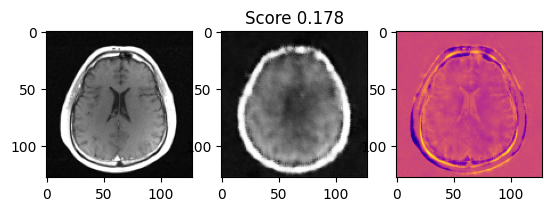

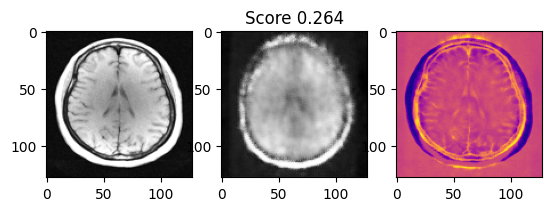

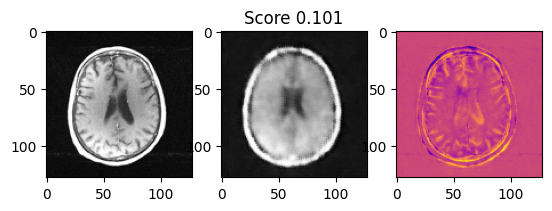

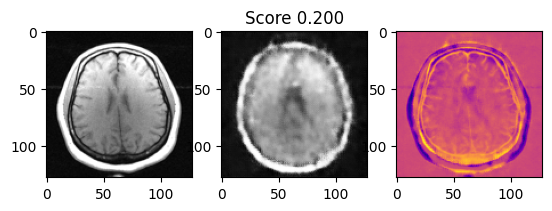

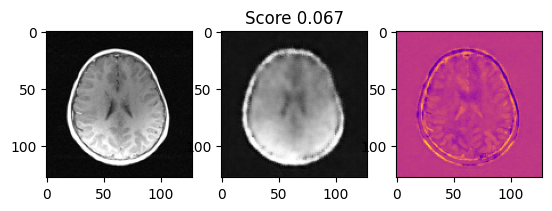

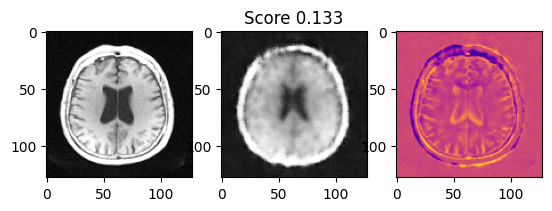

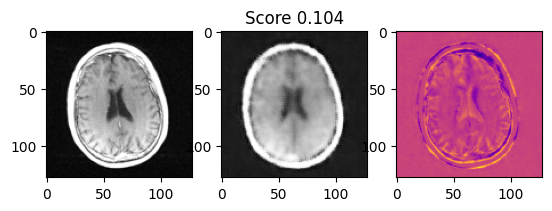

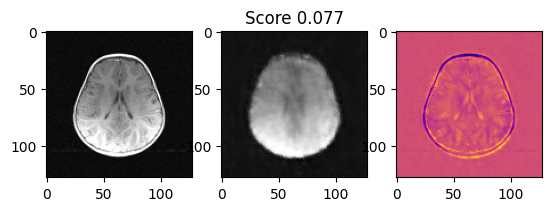

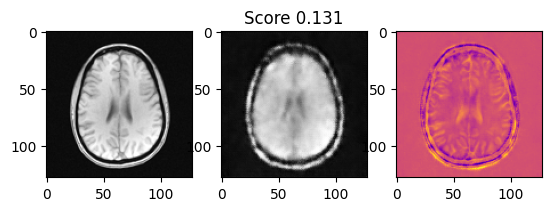

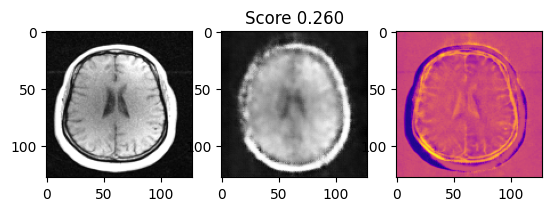

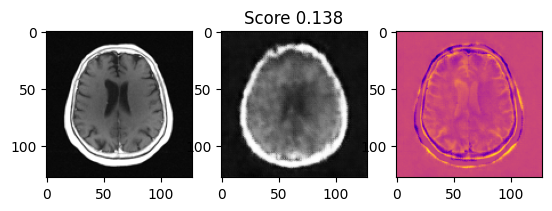

In [36]:
evaluator.plot_in_rec(label="normal", n=16)

## Recon for normal train data

In [37]:
# input_reconstructions_tuples = train_evaluator.label_in_rec_dict["train"]
# N = 8
# fig, ax = plt.subplots(N, 3, figsize=(3,N))
# for i in range(N):
#     input_img, reconstruction_img = input_reconstructions_tuples[i]
#     ax[i][0].imshow(input_img.transpose(1, 2, 0), cmap="gray")
#     # ax[i][0].set_title("Input")
#     ax[i][1].imshow(reconstruction_img.transpose(1, 2, 0), cmap="gray")
#     # ax[i][1].set_title("Reconstruction")
#     diff = input_img - reconstruction_img
#     ax[i][2].imshow(diff.transpose(1, 2, 0), cmap="viridis_r")
#     # ax[i][2].set_title("Difference")
# for ax in ax.flatten():
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.tight_layout()
# plt.show()

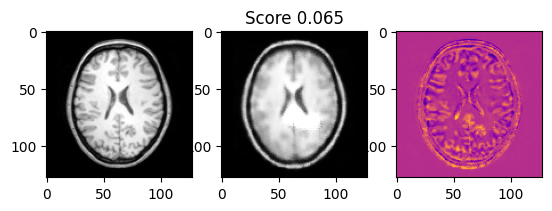

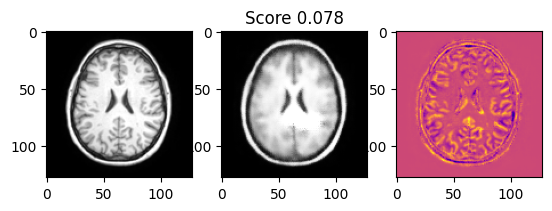

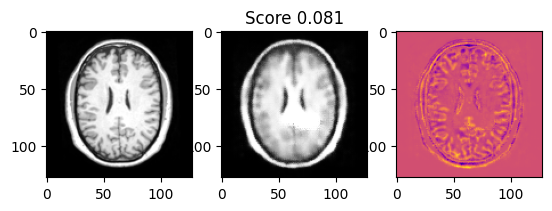

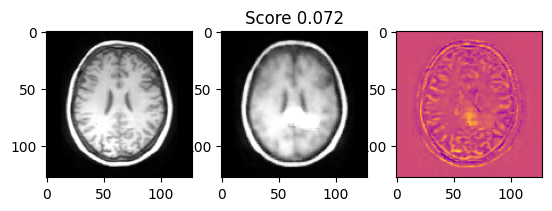

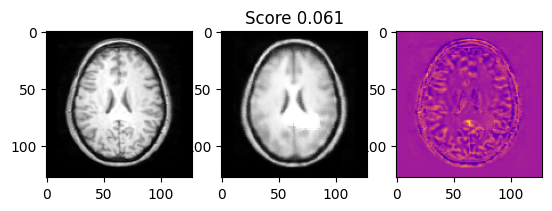

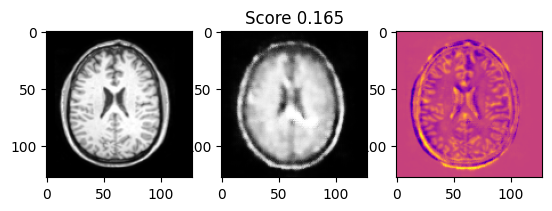

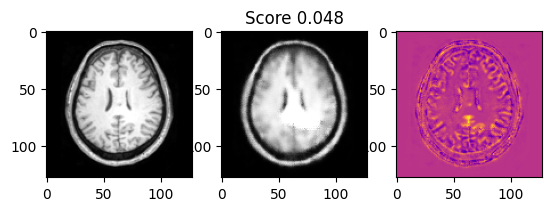

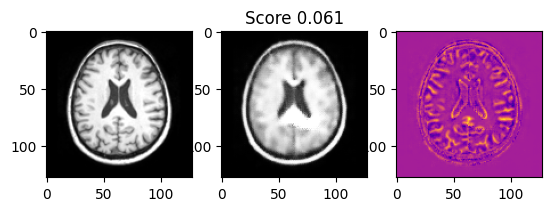

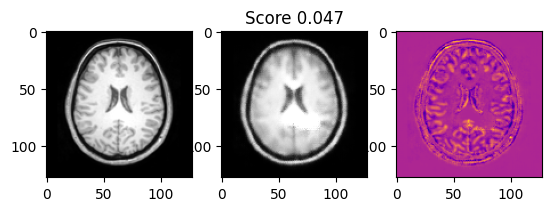

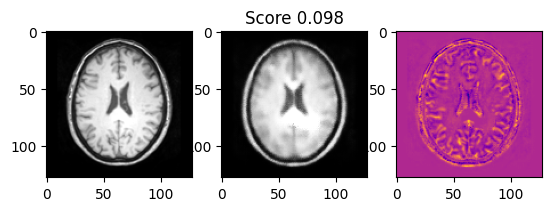

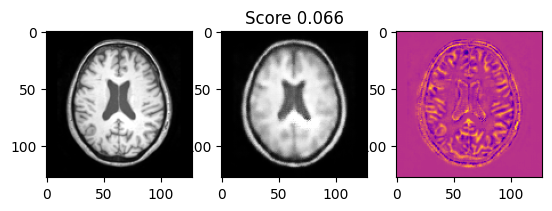

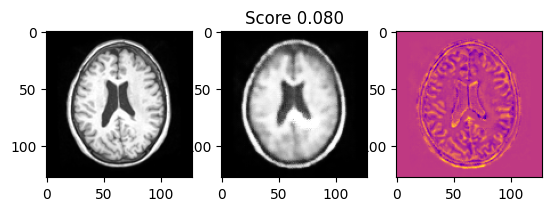

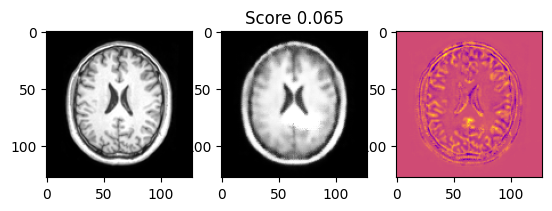

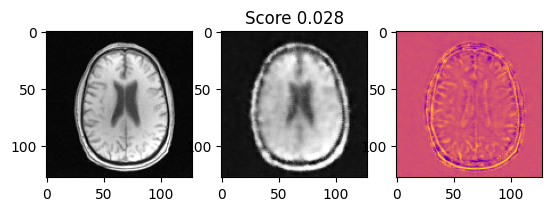

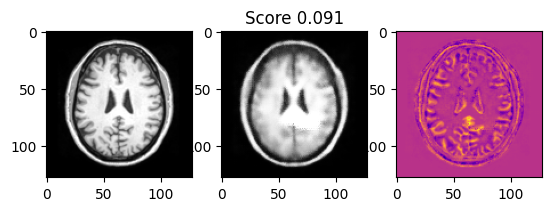

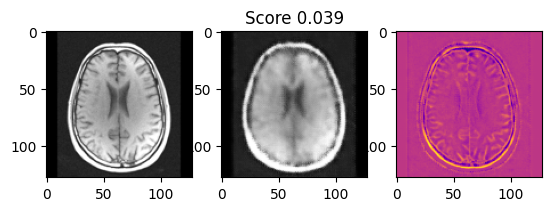

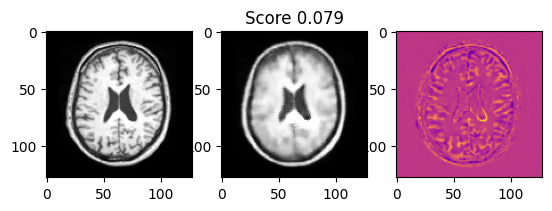

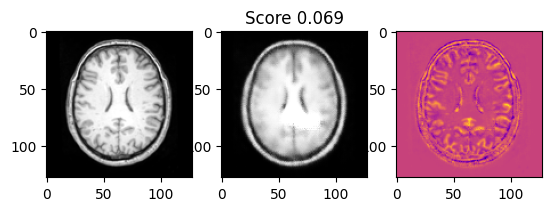

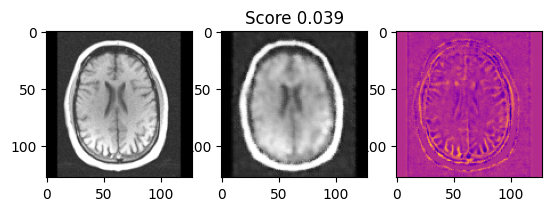

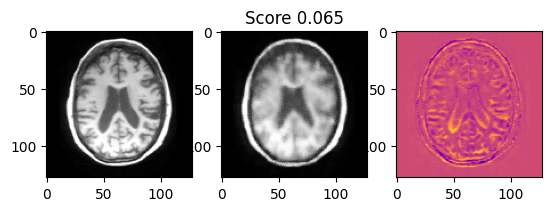

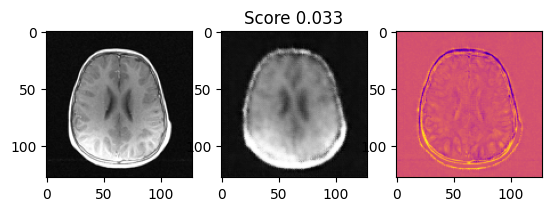

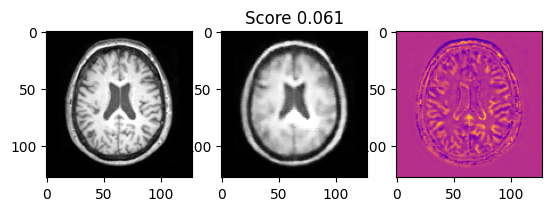

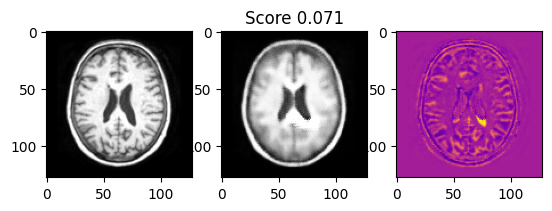

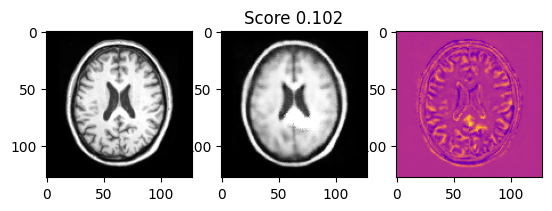

In [38]:
train_evaluator.plot_in_rec(label="train", n=32)


## Recon for abnormal

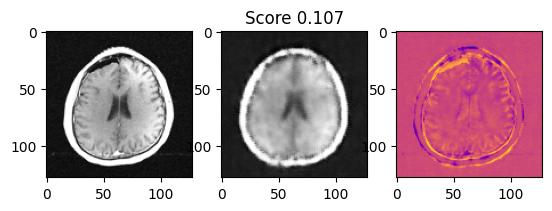

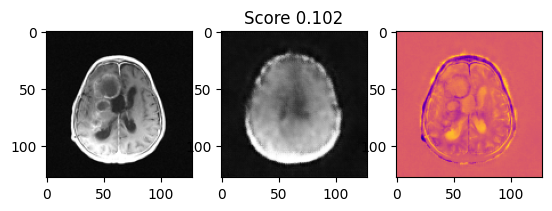

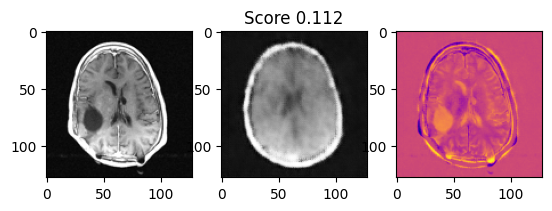

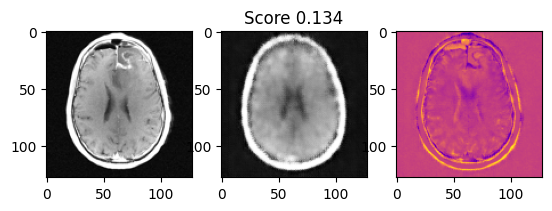

In [39]:
evaluator.plot_in_rec(label="resection", n=8)

In [40]:
# fig_example.savefig(f"example_{config['num_epochs']}.png")